In [29]:
import torch
import numpy as np
from torch import nn
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms as T

In [30]:
BATCH = 1
IMAGE_SIZE = 224
device = "cpu"
weight_path = "./save_weights/best_clf_f88_k35_weights.pt"
class_names = ['christmas tree', 'grinch', 'reindeer', 'santa', 'snowman']

In [31]:
class SimpleCNN(nn.Module):
    def __init__(self, f1, f2, k1, k2, flatten_num, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, f1, kernel_size=k1, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(f1, f2, kernel_size=k2, stride=1, padding=1)
        self.fc1 = nn.Linear(flatten_num, num_classes)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv1(x)
        y = self.relu(x)
        x = self.pool(y)
        x = self.conv2(x)
        z = self.relu(x)
        x = self.pool(z)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x, y, z

model = SimpleCNN(8, 8, 3, 5, 24200, num_classes=len(class_names)).to(device)
model.load_state_dict(torch.load(weight_path, map_location=device))
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=24200, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [32]:
dummy_x = torch.randn(BATCH, 3, IMAGE_SIZE, IMAGE_SIZE)
torch_out, conv1, conv2 = model(dummy_x)

In [33]:
torch.onnx.export(
    model,
    dummy_x,
    "christmas_clf.onnx",
    input_names=["input"],
    output_names=["probas", "conv1", "conv2"],
    verbose=True
)

In [51]:
def to_tensor(image_path: str) :
    transformer = T.Compose([T.Resize((IMAGE_SIZE, IMAGE_SIZE))])
    image = torchvision.io.read_image(image_path).type(torch.float32) / 255.
    x = torchvision.io.read_image(image_path).type(torch.float32) 
    image_transform = transformer(image)
    return x, image_transform.to("cpu")

In [52]:
import onnxruntime
import numpy as np

def infer_onnx_model(model_path, input_data):
    # Create an ONNX runtime inference session
    session = onnxruntime.InferenceSession(model_path)

    # Convert input data to a format that can be fed into the model
    input_name = session.get_inputs()[0].name
    input_data = {input_name: np.array(input_data, dtype=np.float32)}

    # Perform inference
    output = session.run(None, input_data)
    return output

# Example usage
model_path = "christmas_clf.onnx"
a, input_data = to_tensor(r"original_data\grinch\1bFNuNUgrfI4vbhsbvYovCQ.jpg")  # Replace with your input data

result = infer_onnx_model(model_path, input_data.reshape(1, 3, IMAGE_SIZE, IMAGE_SIZE))

c:\Users\alant\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [53]:
def softmax(scores):
    exp_scores = np.exp(scores - np.max(scores))  # Subtracting the maximum score for numerical stability
    probabilities = exp_scores / np.sum(exp_scores, axis=0)
    return probabilities

(-0.5, 223.5, 223.5, -0.5)

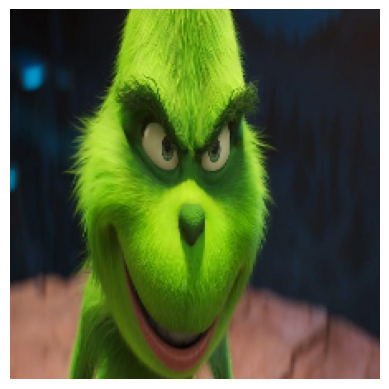

In [54]:
plt.imshow(input_data.permute(1,2,0))
plt.axis(False)

In [55]:
softmax(result[0][0]), softmax(result[0][0]).max(), class_names[result[0][0].argmax()]

(array([8.6860312e-04, 9.9913138e-01, 1.8476614e-08, 1.3675079e-09,
        4.6867132e-08], dtype=float32),
 0.9991314,
 'grinch')

In [70]:
result[1][0].shape

(8, 224, 224)